## **Multi-Layer Perceptron**: Reconocimiento de dígitos manuscritos


En este laboratorio, nuestro objetivo será aplicar la red neuronal Multi-Layer Perceptron (MLP) para efectuar la clasificación de caracteres manuscritos y los cuales pueden obtenerse desde Tensorflow Datasets, ActiveLoop AI, o desde [aquí](https://www.kaggle.com/datasets/hojjatk/mnist-dataset?resource=download)

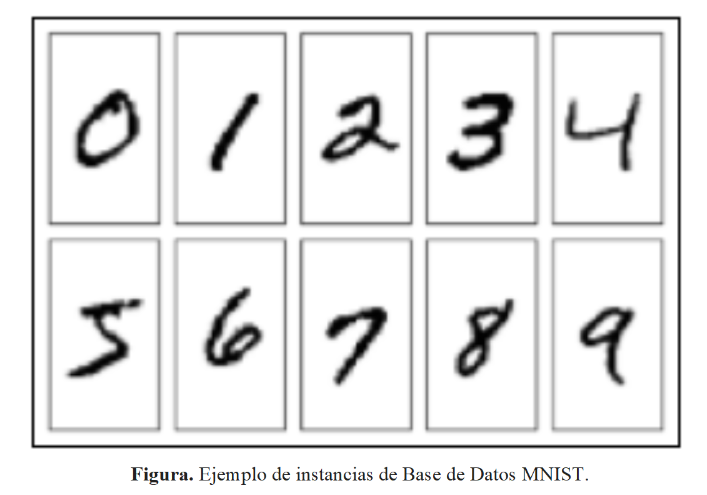

Esta base de datos consiste en ejemplos de imágenes de caracteres manuscritos de dígitos. La misma fue construida por un conjunto de decenas de personas con el fin de capturar la variabilidad de escritura en dígitos manuscritos. MNIST está dividida en una base de datos para entrenar, con 60 000 instancias,y otra para testear, con 10 000 instancias. Cada imagen es de 28x28 píxeles, donde cada píxel está en escala de grises. La información de las clases consiste en los 10 dígitos correspondientes (0-9). Los datos están en formato binario y csv; en este laboratorio usaremos el formato binario ya que es el más rápido de extraer.

1.   Cargue base de datos MNIST a objetos array Numpy de Python, tanto de entrenamiento como de testeo. Use función a mostrar en laboratorio load_mnist. Indique cual par de líneas de código es la más complicada a su juicio, e indique razón.



In [1]:
import os
import struct
import numpy as np

def load_mnist_train(path, kind='train'):
  """Load MNIST data from `path`"""
  labels_path = os.path.join(path,'%s-labels.idx1-ubyte'% kind)
  images_path = os.path.join(path,'%s-images.idx3-ubyte'% kind)

  with open(labels_path, 'rb') as lbpath:
    magic, n = struct.unpack('>II',lbpath.read(8))
    labels = np.fromfile(lbpath,dtype=np.uint8)

  with open(images_path, 'rb') as imgpath:
    magic, num, rows, cols = struct.unpack(">IIII",imgpath.read(16))
    images = np.fromfile(imgpath,dtype=np.uint8).reshape(len(labels), 784)

  return images, labels

¿Por qué leemos de esta forma el dataset? Echemos un vistazo a la descripción proporcionada por la página oficial:

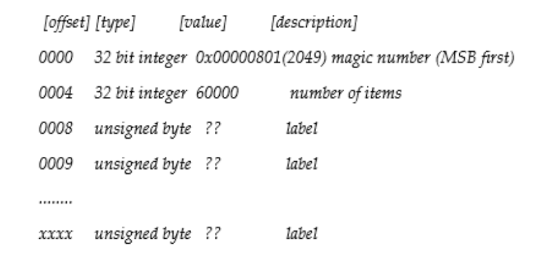

Debido a que estamos leyendo los archivos de forma binaria, es necesario leer, primero, el número mágico (una descripción del protocolo del archivo) y el número de items correspondientes, antes de poder leer los bytes a un array de Numpy

In [2]:
X_train, y_train = load_mnist_train("/content/")

In [3]:
def load_mnist_test(path, kind='test'):
  """Load MNIST data from `path`"""
  labels_path = os.path.join(path,'t10k-labels.idx1-ubyte')
  images_path = os.path.join(path,'t10k-images.idx3-ubyte')

  with open(labels_path, 'rb') as lbpath:
    magic, n = struct.unpack('>II',lbpath.read(8))
    labels = np.fromfile(lbpath,dtype=np.uint8)

  with open(images_path, 'rb') as imgpath:
    magic, num, rows, cols = struct.unpack(">IIII",imgpath.read(16))
    images = np.fromfile(imgpath,dtype=np.uint8).reshape(len(labels), 784)

  return images, labels

X_test, y_test = load_mnist_test("/content/")

2.   Cree código para mostrar ejemplos de imágenes. Muestre 10 imágenes de testeo al azar.



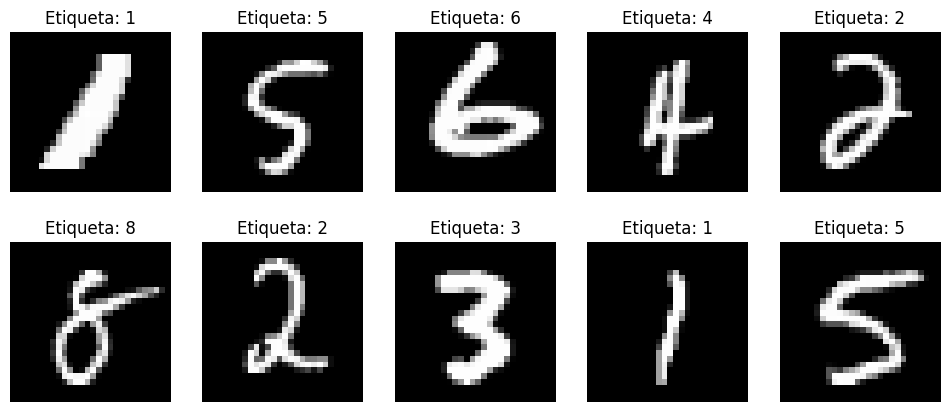

In [37]:
import matplotlib.pyplot as plt

# Selecciona 10 índices aleatorios
indices = np.random.choice(len(X_train), 10, replace=False)

# Muestra las imágenes
plt.figure(figsize=(12, 5))
for i, idx in enumerate(indices):
  plt.subplot(2, 5, i + 1)
  plt.imshow(X_train[idx].reshape(28, 28), cmap='gray')
  #plt.title(f"Etiqueta: {y_train[idx]}")
  plt.axis('off')

plt.show()

3.   Revise implementación de red neuronal, particularmente el algoritmo BackPropagation para el aprendizaje. Considere librería dada en laboratorio. Comente librería presentada al menos 20 líneas y presente librería comentada.



In [39]:
from re import S
import numpy as np
from scipy.special import expit
import sys

class NeuralNetMLP(object):
  """ Feedforward neural network / Multi-layer perceptron classifier.

  Parameters
  ------------
  n_output : int
    Number of output units, should be equal to the
    number of unique class labels.

  n_features : int
    Number of features (dimensions) in the target dataset.
    Also, number of nodes in

  n_hidden : int (default: 30)
    Number of hidden units.

  l1 : float (default: 0.0)
    Lambda value for L1-regularization.
    No regularization if l1=0.0 (default)

  l2 : float (default: 0.0)
    Regularization parameter for L2-regularization.
    No regularization if l2=0.0 (default)

  epochs : int (default: 500)
    Number of passes over the training set.

  eta : float (default: 0.001)
    Learning rate

  alpha : float (default: 0.0)
    Momentum constant. Factor multiplied with the gradient of the previous epoch t-1 to improve learning speed
    w(t) := w(t) - (grad(t) - alpha*grad(t-1))

  decrease_const : float (default: 0.0)
    Decrease constant. Shrinks the learning rate after each epoch via eta / (1 + epoch*decrease_const)

  shuffle : bool (default: True)
    Shuffles training data every epoch if True to prevent circles.

  minibatches : int (default: 1)
    Divides training data into k minibatches for efficiency
    Normal gradient descent learning k=1 (default)

  random_state : int (default: None)
    Set random state for shuffling and initializing the weights.

  Attributes
  -----------
  cost_ : list
    Sum of squared errors after each epoch.
  """

  def __init__(self, n_output, n_features, n_hidden=30, l1=0.0, l2=0.0, epochs=500, eta=0.001,
               alpha=0.0, decrease_const=0.0, shuffle=True, minibatches=1, random_state=None):

    np.random.seed(random_state)
    self.n_output = n_output
    self.n_features = n_features
    self.n_hidden = n_hidden
    self.l1 = l1
    self.l2 = l2
    self.epochs = epochs
    self.eta = eta
    self.alpha = alpha
    self.decrease_const = decrease_const
    self.shuffle = shuffle
    self.minibatches = minibatches

    self.w1, self.w2 = self._initialize_weights()

  def _encode_labels(self, y, k):
      """Encode labels into one-hot representation
      Parameters
      ------------
      y : array, shape = [n_samples]
          Target values.
      Returns
      ----------
      onehot : array, shape = [n_labels, n_samples]
      """

      onehot = np.zeros((k, y.shape[0]))

      for idx, val in enumerate(y):
          onehot[val, idx] = 1.0

      return onehot

  def _initialize_weights(self):
      """Initialize weights with small random numbers."""
      w1 = np.random.uniform(-1.0, 1.0,
                            size=self.n_hidden * (self.n_features + 1))
      w1 = w1.reshape(self.n_hidden, self.n_features + 1)
      w2 = np.random.uniform(-1.0, 1.0,
                            size=self.n_output * (self.n_hidden + 1))
      w2 = w2.reshape(self.n_output, self.n_hidden + 1)
      return w1, w2

  def _sigmoid(self, z):
      """Compute logistic function (sigmoid)
      Uses scipy.special.expit to avoid overflow
      error for very small input values
      """
      # return 1.0 / (1.0 + np.exp(-z))
      return expit(z)

  def _sigmoid_gradient(self, z):
      """Compute gradient of the logistic function"""
      sg = self._sigmoid(z)
      return sg * (1 - sg)

  def _add_bias_unit(self, X, how='column'):
      """Add bias unit (column or row of 1s) to array at index 0"""
      if how == 'column':
          X_new = np.ones((X.shape[0], X.shape[1] + 1))
          X_new[:, 1:] = X
      elif how == 'row':
          X_new = np.ones((X.shape[0]+1, X.shape[1]))
          X_new[1:, :] = X
      else:
          raise AttributeError('`how` must be `column` or `row`')

      return X_new

  def _feedforward(self, X, w1, w2):
    """Compute feedforward step

    Parameters
    -----------
    X : array, shape = [n_samples, n_features]
      Input layer with original features
    w1 : array, shape = [n_hidden_units, n_features]
      Weight matrix for input layer -> hidden layer.
    w2 : array, shape = [n_output_units, n_hidden_units]
      Weight matrix for hidden layer -> output layer.

    Returns
    -----------
    a1 : array, shape = [n_samples, n_features+1]
      Input values with bias unit.
    z2 : array, shape = [n_hidden, n_samples]
      Net input of hidden layer.
    a2 : array, shape = [n_hidden+1, n_samples]
      Activation of hidden layer.
    z3 : array, shape = [n_output_units, n_samples]
      Net input of output layer.
    a3 : array, shape = [n_output_units, n_samples]
      Activation of output layer.

    """

    a1 = self._add_bias_unit(X, how='column')
    z2 = w1.dot(a1.T)
    a2 = self._sigmoid(z2)
    a2 = self._add_bias_unit(a2, how='row')
    z3 = w2.dot(a2)
    a3 = self._sigmoid(z3)
    return a1, z2, a2, z3, a3

  def _L2_reg(self, lambda_, w1, w2):
      """Compute L2-regularization cost"""
      return (lambda_ / 2.0) * (np.sum(w1[:, 1:] ** 2) +
                                np.sum(w2[:, 1:] ** 2))

  def _L1_reg(self, lambda_, w1, w2):
      """Compute L1-regularization cost"""
      return (lambda_ / 2.0) * (np.abs(w1[:, 1:]).sum() +
                                np.abs(w2[:, 1:]).sum())

  def _get_cost(self, y_enc, output, w1, w2):
      """Compute cost function.

      Parameters
      ----------
      y_enc : array, shape = (n_labels, n_samples)
        one-hot encoded class labels.
      output : array, shape = [n_output_units, n_samples]
        Activation of the output layer (feedforward)
      w1 : array, shape = [n_hidden_units, n_features]
        Weight matrix for input layer -> hidden layer.
      w2 : array, shape = [n_output_units, n_hidden_units]
        Weight matrix for hidden layer -> output layer.

      Returns
      ---------
      cost : float
        Regularized cost.
      """

      term1 = -y_enc * (np.log(output))
      term2 = (1 - y_enc) * np.log(1 - output)
      cost = np.sum(term1 - term2)
      L1_term = self._L1_reg(self.l1, w1, w2)
      L2_term = self._L2_reg(self.l2, w1, w2)
      cost = cost + L1_term + L2_term
      return cost

  def _get_gradient(self, a1, a2, a3, z2, y_enc, w1, w2):
      """ Compute gradient step using backpropagation.

      Parameters
      ----------
      a1 : array, shape = [n_samples, n_features+1]
        Input values with bias unit.
      a2 : array, shape = [n_hidden+1, n_samples]
        Activation of hidden layer.
      a3 : array, shape = [n_output_units, n_samples]
        Activation of output layer.
      z2 : array, shape = [n_hidden, n_samples]
        Net input of hidden layer.
      y_enc : array, shape = (n_labels, n_samples)
        one-hot encoded class labels.
      w1 : array, shape = [n_hidden_units, n_features]
        Weight matrix for input layer -> hidden layer.
      w2 : array, shape = [n_output_units, n_hidden_units]
        Weight matrix for hidden layer -> output layer

      Returns
      ---------
      grad1 : array, shape = [n_hidden_units, n_features]
        Gradient of the weight matrix w1.
      grad2 : array, shape = [n_output_units, n_hidden_units]
        Gradient of the weight matrix w2.
      """

      #backpropagation
      sigma3 = a3 - y_enc
      z2 = self._add_bias_unit(z2, how='row')
      sigma2 = w2.T.dot(sigma3) * self._sigmoid_gradient(z2)
      sigma2 = sigma2[1:, :]
      grad1 = sigma2.dot(a1)
      grad2 = sigma3.dot(a2.T)

      #regularize
      grad1[:, 1:] += (w1[:, 1:] * (self.l1 + self.l2))
      grad2[:, 1:] += (w2[:, 1:] * (self.l1 + self.l2))

      return grad1, grad2

  def predict(self, X):
      """Predict class labels

      Parameters
      -----------
      X : array, shape = [n_samples, n_features]
        Input layer with original features.

      Returns:
      ----------
      y_pred : array, shape = [n_samples]
        Predicted class labels.
      """

      if len(X.shape) != 2:
        raise AttributeError('X must be a [n_samples, n_features] array.\n'
                            'Use X[:,None] for 1-feature classification.'
                            '\nor X[[i]] for 1-sample classification')

      a1, z2, a2, z3, a3 = self._feedforward(X, self.w1, self.w2)
      y_pred = np.argmax(z3, axis=0)
      return y_pred

  def fit(self, X, y, print_progress=False):
      """ Learn weights from training data.

      Parameters
      -----------
      X : array, shape = [n_samples, n_features]
        Input layer with original features.
      y : array, shape = [n_samples]
        Target class labels.
      print_progress : bool (default: False)
        Prints progress as the number of epochs
        to stderr.

      Returns:
      ----------
      self
      """

      self.cost_ = []
      X_data, y_data = X.copy(), y.copy()
      y_enc = self._encode_labels(y, self.n_output)

      delta_w1_prev = np.zeros(self.w1.shape)
      delta_w2_prev = np.zeros(self.w2.shape)

      for i in range(self.epochs):

        # adaptive learning rate
        self.eta /= (1 + self.decrease_const * i)

        if print_progress:
          sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
          sys.stderr.flush

        if self.shuffle:
          idx = np.random.permutation(y_data.shape[0])
          X_data, y_enc = X_data[idx], y_enc[:, idx]

        mini = np.array_split(range(y_data.shape[0]), self.minibatches)

        for idx in mini:

          # feedforward
          a1, z2, a2, z3, a3 = self._feedforward(X_data[idx], self.w1, self.w2)
          cost = self._get_cost(y_enc=y_enc[:, idx], output=a3, w1=self.w1, w2=self.w2)
          self.cost_.append(cost)

          #compute gradient via backpropagation
          grad1, grad2 = self._get_gradient(a1=a1, a2=a2, a3=a3, z2=z2, y_enc=y_enc[:, idx], w1=self.w1, w2=self.w2)
          delta_w1, delta_w2 = self.eta * grad1, self.eta * grad2
          self.w1 -= (delta_w1 + (self.alpha * delta_w1_prev))
          self.w2 -= (delta_w2 + (self.alpha * delta_w2_prev))
          delta_w1_prev, delta_w2_prev = delta_w1, delta_w2

      return self


4.   Entrene red neuronal y aplíquela en dataset MNIST (set de entrenamiento). Considere las siguientes configuraciones: 784-10-10, 784-30-10 784-50-10, 784-70-10 y 784-100-10 con un máximo de 1000 épocas. Plotee proceso de entrenamiento por cada configuración dada considerando el promedio de error por batch.



In [48]:
nn = NeuralNetMLP(n_output=10,
                  n_features=X_train.shape[1],
                  n_hidden=10,
                  l2=0.1,
                  l1=0.0,
                  epochs=1000,
                  eta=0.001,
                  alpha=0.001,
                  decrease_const=0.00001,
                  minibatches=50,
                  shuffle=True,
                  random_state=1)

nn.fit(X_train, y_train, print_progress=True)

batches = np.array_split(range(len(nn.cost_)), nn.minibatches)
cost_ary = np.array(nn.cost_)
cost_avgs = [np.mean(cost_ary[i]) for i in batches]

Epoch: 1000/1000

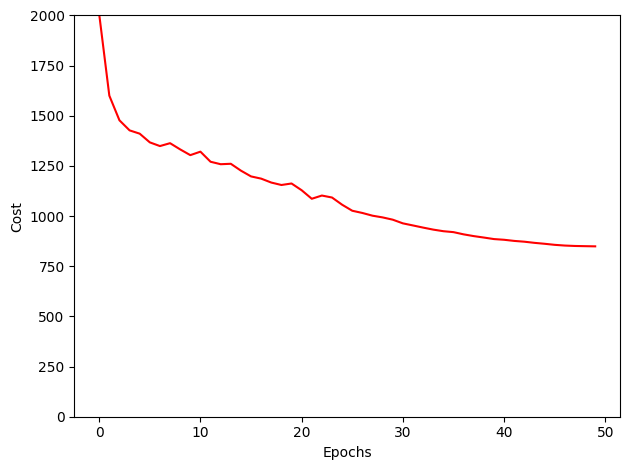

In [49]:
plt.plot(range(len(cost_avgs)), cost_avgs, color='red')
plt.ylim([0, 2000])
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.tight_layout()
# plt.savefig('./figures/cost2.png, dpi=300)
plt.show()

5.   Muestre error de predicción en set de entrenamiento para cada configuración. A continuación muestre error de predicción en set de testeo. Explique resultados.



In [50]:
y_train_pred = nn.predict(X_train)
acc = np.sum(y_train == y_train_pred, axis=0) / X_train.shape[0]
print('Training accuracy: %.2f%%' % (acc * 100))

y_test_pred = nn.predict(X_test)
acc = np.sum(y_test == y_test_pred, axis=0) / X_test.shape[0]
print('Test accuracy: %.2f%%' % (acc * 100))

Training accuracy: 91.54%
Test accuracy: 90.33%
